In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
import json
from sklearn.metrics import roc_auc_score, average_precision_score, \
precision_score, recall_score, f1_score
%store -r time_window
%store -r lab_feature_space

May 15, 2024 Update: change all validation from 10-fold CV to one-vs-all method.  
Still change back to most frequent measure
Tomorrow modify weight combo search

May 16, 2024 Update: It seems that weight should be dynamic. Increase the portion of test set. 
Maybe for lab overlap rate, some indicator like BUN should be penalized more than others.

In [2]:
len(lab_feature_space)

40

In [3]:
num_processors = multiprocessing.cpu_count()

In [4]:
dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset.csv")

In [5]:
#data overlap rate (entire dataset)
SCR_overlap = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap.npy')
LAB_overlap = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap.npy')

In [6]:
assert(SCR_overlap.shape[0] == LAB_overlap.shape[0])
assert(~np.isnan(SCR_overlap).any())
assert(~np.isnan(LAB_overlap).any())

In [7]:
# no need to shuffle again since we have done it.
%store -r train_len
%store -r test_len

data_train = dataset.iloc[:train_len, :].copy(deep = True)
data_test = dataset.iloc[train_len:, :].copy(deep = True)

In [8]:
assert((len(data_train) + len(data_test)) == len(dataset))

In [9]:
# normalize the dataset by train and test
data_train = (data_train - data_train.min(skipna=True)) / \
(data_train.max(skipna=True) - data_train.min(skipna=True))

data_test = (data_test - data_test.min(skipna=True)) / \
(data_test.max(skipna=True) - data_test.min(skipna=True))

Note: train is patient pool, dev is for grid search, test is for testing performance. val is train + dev, train is train + test.

In [10]:
# consequently, we will only use the upper-left block of the overlap rate mtx for just val set
SCR_overlap_train = SCR_overlap[:len(data_train), :len(data_train)]
LAB_overlap_train = LAB_overlap[:len(data_train), :len(data_train)]

# Compute SCr Similarity 

Methods: DTW-AROW on raw, linear interpolation + Euclidean distance, cosine similarity, Manhattan

1. DTW-AROW

In [11]:
# to compute similarity mtx on SCR, we still need to compute the global
# SCR similarity mtx (so that we can use well-written functions)
# DTW-AROW
import sys
sys.path.append('/home/lideyi/AKI_Personalization_Methodology/DTW_with_missing_values')
import dtw_missing.dtw_missing as dtw_m
import nbimporter
from Z_Helping_Functions import translate_dist_mtx_to_simi, \
fast_argsort, slow_argsort, min_max_normalization

In [12]:
# get SCR measurements for val(i.e. both train and dev)
SCR = dataset.loc[:, time_window]

In [13]:
def parallel_distance_matrix(df, num_processes, metric):
    pool = Pool(num_processes)
    total = len(df)

    results = list(tqdm(pool.imap(calculate_overlap, 
                                  [(i, df, metric) for i in range(total - 1)]), 
                            total=total - 1))
    pool.close()
    pool.join()
    return create_distance_matrix(results)

In [14]:
def calculate_overlap(args):
    index, df, metric = args
    return [metric(df.iloc[index], df.iloc[j]) for j in range(index + 1, len(df))]

In [15]:
def create_distance_matrix(distance_list):
    n = len(distance_list[0]) + 1

    matrix = np.zeros((n, n))

    for i in range(n-1):
        matrix[i, i+1:i+1+len(distance_list[i])] = distance_list[i]

    for i in range(n):
        for j in range(i+1, n):
            matrix[j, i] = matrix[i, j]
    return matrix

In [16]:
def get_DTW_distance(u, v):
    u = np.array(u)
    v = np.array(v)
    d = dtw_m.warping_paths(u, v)[0]
    return d

In [17]:
SCR_DTW_dist = parallel_distance_matrix(SCR, num_processors, get_DTW_distance)
np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput1.npy', SCR_DTW_dist)

100%|██████████| 20536/20536 [1:16:27<00:00,  4.48it/s]  


In [18]:
SCR_DTW_dist = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput1.npy')

In [19]:
# transfrom distance mtx to similarity score mtx by min-max normalization
SCR_DTW_simi = translate_dist_mtx_to_simi(SCR_DTW_dist)
# transform similarity score mtx to idx matrix by most similar rank highest
SCR_DTW_idx = fast_argsort(SCR_DTW_simi, num_processors)

In [20]:
SCR_DTW_dist_train = SCR_DTW_dist[:len(data_train), :len(data_train)]
SCR_DTW_simi_train = translate_dist_mtx_to_simi(SCR_DTW_dist_train)
SCR_DTW_idx_train = fast_argsort(SCR_DTW_simi_train, num_processors)

In [21]:
assert(~np.isnan(SCR_DTW_simi).any())
assert(~np.isnan(SCR_DTW_idx).any())
assert(~np.isnan(SCR_DTW_simi_train).any())
assert(~np.isnan(SCR_DTW_idx_train).any())

2. Euclidean distance

In [22]:
# Euclidean distance and following methods do not support missing values.
# we need use mean to fill in missing values
SCR_ip = SCR.fillna(SCR.mean())

In [23]:
from sklearn.metrics import pairwise_distances

In [24]:
SCR_Euc_dist = pairwise_distances(SCR_ip, metric='euclidean', n_jobs=-1)
SCR_Euc_simi = translate_dist_mtx_to_simi(SCR_Euc_dist)
SCR_Euc_idx = fast_argsort(SCR_Euc_simi, num_processors)

In [25]:
SCR_Euc_dist_train = SCR_Euc_dist[:len(data_train), :len(data_train)]
SCR_Euc_simi_train = translate_dist_mtx_to_simi(SCR_Euc_dist_train)
SCR_Euc_idx_train = fast_argsort(SCR_Euc_simi_train, num_processors)

In [26]:
assert(~np.isnan(SCR_Euc_simi).any())
assert(~np.isnan(SCR_Euc_idx).any())
assert(~np.isnan(SCR_Euc_simi_train).any())
assert(~np.isnan(SCR_Euc_idx_train).any())

3. Cosine

In [27]:
SCR_Cos_dist = pairwise_distances(SCR_ip, metric='cosine', n_jobs=-1)
SCR_Cos_simi = translate_dist_mtx_to_simi(SCR_Cos_dist)
SCR_Cos_idx = fast_argsort(SCR_Cos_simi, num_processors)

In [28]:
SCR_Cos_dist_train = SCR_Cos_dist[:len(data_train), :len(data_train)]
SCR_Cos_simi_train = translate_dist_mtx_to_simi(SCR_Cos_dist_train)
SCR_Cos_idx_train = fast_argsort(SCR_Cos_simi_train, num_processors)

In [29]:
assert(~np.isnan(SCR_Cos_simi).any())
assert(~np.isnan(SCR_Cos_idx).any())
assert(~np.isnan(SCR_Cos_simi_train).any())
assert(~np.isnan(SCR_Cos_idx_train).any())

4. Manhattan

In [30]:
SCR_Manh_dist = pairwise_distances(SCR_ip, metric='manhattan', n_jobs=-1)
SCR_Manh_simi = translate_dist_mtx_to_simi(SCR_Manh_dist)
SCR_Manh_idx = fast_argsort(SCR_Manh_simi, num_processors)

In [31]:
SCR_Manh_dist_train = SCR_Manh_dist[:len(data_train), :len(data_train)]
SCR_Manh_simi_train = translate_dist_mtx_to_simi(SCR_Manh_dist_train)
SCR_Manh_idx_train = fast_argsort(SCR_Manh_simi_train, num_processors)

In [32]:
assert(~np.isnan(SCR_Cos_simi).any())
assert(~np.isnan(SCR_Cos_idx).any())
assert(~np.isnan(SCR_Cos_simi_train).any())
assert(~np.isnan(SCR_Cos_idx_train).any())

# Compute Lab Similarity 

Replace missing value by mean

In [33]:
LAB_train = data_train.loc[:, lab_feature_space]
LAB_test = data_test.loc[:, lab_feature_space]

In [34]:
#replace the entire lab feature space with imputated value
LAB_train.loc[:, :] = LAB_train.fillna(LAB_train.mean())
LAB_test.loc[:, :] = LAB_test.fillna(LAB_test.mean())

In [35]:
# we concate train and test back together to facilitate computing
# but still metric is learned from train data
LAB_ip = pd.concat([LAB_train, LAB_test], axis = 0)

1. Use Euclidean Distance to measure Lab

In [36]:
LAB_Euc_dist = pairwise_distances(LAB_ip, metric='euclidean', n_jobs=-1)
LAB_Euc_simi = translate_dist_mtx_to_simi(LAB_Euc_dist)
LAB_Euc_idx = fast_argsort(LAB_Euc_simi, num_processors)

In [37]:
LAB_Euc_dist_train = LAB_Euc_dist[:len(data_train), :len(data_train)]
LAB_Euc_simi_train = translate_dist_mtx_to_simi(LAB_Euc_dist_train)
LAB_Euc_idx_train = fast_argsort(LAB_Euc_simi_train, num_processors)

In [38]:
assert(~np.isnan(LAB_Euc_simi).any())
assert(~np.isnan(LAB_Euc_idx).any())
assert(~np.isnan(LAB_Euc_simi_train).any())
assert(~np.isnan(LAB_Euc_idx_train).any())

2. Use Cosine Distance to measure Lab

In [39]:
LAB_Cos_dist = pairwise_distances(LAB_ip, metric='cosine', n_jobs=-1)
LAB_Cos_simi = translate_dist_mtx_to_simi(LAB_Cos_dist)
LAB_Cos_idx = fast_argsort(LAB_Cos_simi, num_processors)

In [40]:
LAB_Cos_dist_train = LAB_Cos_dist[:len(data_train), :len(data_train)]
LAB_Cos_simi_train = translate_dist_mtx_to_simi(LAB_Cos_dist_train)
LAB_Cos_idx_train = fast_argsort(LAB_Cos_simi_train, num_processors)

In [41]:
assert(~np.isnan(LAB_Cos_simi).any())
assert(~np.isnan(LAB_Cos_idx).any())
assert(~np.isnan(LAB_Cos_simi_train).any())
assert(~np.isnan(LAB_Cos_idx_train).any())

3. Use Manhattan Distance to measure Lab

In [42]:
LAB_Manh_dist = pairwise_distances(LAB_ip, metric='manhattan', n_jobs=-1)
LAB_Manh_simi = translate_dist_mtx_to_simi(LAB_Manh_dist)
LAB_Manh_idx = fast_argsort(LAB_Manh_simi, num_processors)

In [43]:
LAB_Manh_dist_train = LAB_Manh_dist[:len(data_train), :len(data_train)]
LAB_Manh_simi_train = translate_dist_mtx_to_simi(LAB_Manh_dist_train)
LAB_Manh_idx_train = fast_argsort(LAB_Manh_simi_train, num_processors)

In [44]:
assert(~np.isnan(LAB_Manh_simi).any())
assert(~np.isnan(LAB_Manh_idx).any())
assert(~np.isnan(LAB_Manh_simi_train).any())
assert(~np.isnan(LAB_Manh_idx_train).any())

# Weighting Each Simi Mtx Computed Above by Overlap Rates and Re-estimate Idx Mtx

In [45]:
def weighted_by_overlap_mtx(overlap_mtx, simi_mtx, num_processors):
    weighted_simi = overlap_mtx * simi_mtx
    weighted_idx = fast_argsort(weighted_simi, num_processors)
    return weighted_simi, weighted_idx

In [46]:
# val
# for all SCR similarity mtx
SCR_DTW_simi_w, SCR_DTW_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_DTW_simi, num_processors)
SCR_Euc_simi_w, SCR_Euc_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Euc_simi, num_processors)
SCR_Cos_simi_w, SCR_Cos_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Cos_simi, num_processors)
SCR_Manh_simi_w, SCR_Manh_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Manh_simi, num_processors)

# for all LAB similarity mtx
LAB_Euc_simi_w, LAB_Euc_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Euc_simi, num_processors)
LAB_Cos_simi_w, LAB_Cos_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Cos_simi, num_processors)
LAB_Manh_simi_w, LAB_Manh_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Manh_simi, num_processors)

In [47]:
# train
# for all SCR similarity mtx
SCR_DTW_simi_w_train, SCR_DTW_idx_w_train = weighted_by_overlap_mtx(SCR_overlap_train, SCR_DTW_simi_train, num_processors)
SCR_Euc_simi_w_train, SCR_Euc_idx_w_train = weighted_by_overlap_mtx(SCR_overlap_train, SCR_Euc_simi_train, num_processors)
SCR_Cos_simi_w_train, SCR_Cos_idx_w_train = weighted_by_overlap_mtx(SCR_overlap_train, SCR_Cos_simi_train, num_processors)
SCR_Manh_simi_w_train, SCR_Manh_idx_w_train = weighted_by_overlap_mtx(SCR_overlap_train, SCR_Manh_simi_train, num_processors)

# for all LAB similarity mtx
LAB_Euc_simi_w_train, LAB_Euc_idx_w_train = weighted_by_overlap_mtx(LAB_overlap_train, LAB_Euc_simi_train, num_processors)
LAB_Cos_simi_w_train, LAB_Cos_idx_w_train = weighted_by_overlap_mtx(LAB_overlap_train, LAB_Cos_simi_train, num_processors)
LAB_Manh_simi_w_train, LAB_Manh_idx_w_train = weighted_by_overlap_mtx(LAB_overlap_train, LAB_Manh_simi_train, num_processors)

# Summary of Similarity Idx Matrices, Sanity Check and Organize them into Dictionary

The similarity idx matrix is for the entire data(train + test). We only need the neareast neighbors in training data for each test data point. Thus we organize them into dictionaries. Keys are the index of each test data point and values are lists of the indicies of nearest training data point.

In [48]:
from sklearn.model_selection import KFold

In [49]:
# get idx to process dicts
train_idx = np.array(data_train.index)

In [50]:
# generate simi_dict for one-vs-all val
def process_similarity_arr_for_train(train_idx, y_train, simi_mtx, idx_mtx):
    neighbor_idx = remove_elements_equal_to_row_index(idx_mtx)
    
    neighbor_simi = extract_elements_based_on_indices(neighbor_idx, simi_mtx)
    
    y_train_arr = np.tile(y_train, (neighbor_idx.shape[0], 1))
    
    neighbor_y = extract_elements_based_on_indices(neighbor_idx, y_train_arr)
    
    assert(neighbor_simi.shape[1] == neighbor_y.shape[1])
    
    return neighbor_simi, neighbor_y

In [51]:
def extract_elements_based_on_indices(idx_mtx, base_mtx):
    # Convert the input matrices to NumPy arrays for easier manipulation
    
    if np.any(idx_mtx >= base_mtx.shape[1]) or np.any(idx_mtx < 0):
        raise ValueError("Matrix A contains indices that are out of bounds for Matrix B")
    
    # Use advanced indexing to select the elements from matrix_b
    row_indices = np.arange(idx_mtx.shape[0])[:, None]  # Create an array of row indices
    result_matrix = base_mtx[row_indices, idx_mtx]  # Use the row indices and matrix_a for advanced indexing
    
    return result_matrix

In [52]:
def remove_elements_equal_to_row_index(matrix):
    # Convert the input matrix to a NumPy array for easier manipulation
    matrix = np.array(matrix)
    
    # Create a list to hold the new rows
    new_matrix = []
    
    # Iterate through each row in the matrix
    for row_index in range(matrix.shape[0]):
        # Get the current row
        row = matrix[row_index]
        # Create a new row excluding the element equal to the row index
        new_row = row[row != row_index]
        # Append the new row to the new_matrix list
        new_matrix.append(new_row)
    
    # Convert the list of rows back to a NumPy array
    new_matrix = np.array(new_matrix)
    
    return new_matrix

In [53]:
y_train = np.array(data_train["AKI_LABEL"])

In [54]:
SCR_DTW_simi_train_clean, SCR_DTW_y_train_clean = process_similarity_arr_for_train(train_idx, y_train, SCR_DTW_simi_train, SCR_DTW_idx_train)
SCR_DTW_simi_w_train_clean, SCR_DTW_y_w_train_clean = process_similarity_arr_for_train(train_idx, y_train, SCR_DTW_simi_w_train, SCR_DTW_idx_w_train)

SCR_Euc_simi_train_clean, SCR_Euc_y_train_clean = process_similarity_arr_for_train(train_idx, y_train, SCR_Euc_simi_train, SCR_Euc_idx_train)
SCR_Euc_simi_w_train_clean, SCR_Euc_y_w_train_clean = process_similarity_arr_for_train(train_idx, y_train, SCR_Euc_simi_w_train, SCR_Euc_idx_w_train)

SCR_Cos_simi_train_clean, SCR_Cos_y_train_clean = process_similarity_arr_for_train(train_idx, y_train, SCR_Cos_simi_train, SCR_Cos_idx_train)
SCR_Cos_simi_w_train_clean, SCR_Cos_y_w_train_clean = process_similarity_arr_for_train(train_idx, y_train, SCR_Cos_simi_w_train, SCR_Cos_idx_w_train)

SCR_Manh_simi_train_clean, SCR_Manh_y_train_clean = process_similarity_arr_for_train(train_idx, y_train, SCR_Manh_simi_train, SCR_Manh_idx_train)
SCR_Manh_simi_w_train_clean, SCR_Manh_y_w_train_clean = process_similarity_arr_for_train(train_idx, y_train, SCR_Manh_simi_w_train, SCR_Manh_idx_w_train)

In [55]:
LAB_Euc_simi_train_clean, LAB_Euc_y_train_clean = process_similarity_arr_for_train(train_idx, y_train, LAB_Euc_simi_train, LAB_Euc_idx_train)
LAB_Euc_simi_w_train_clean, LAB_Euc_y_w_train_clean = process_similarity_arr_for_train(train_idx, y_train, LAB_Euc_simi_w_train, LAB_Euc_idx_w_train)

LAB_Cos_simi_train_clean, LAB_Cos_y_train_clean = process_similarity_arr_for_train(train_idx, y_train, LAB_Cos_simi_train, LAB_Cos_idx_train)
LAB_Cos_simi_w_train_clean, LAB_Cos_y_w_train_clean = process_similarity_arr_for_train(train_idx, y_train, LAB_Cos_simi_w_train, LAB_Cos_idx_w_train)

LAB_Manh_simi_train_clean, LAB_Manh_y_train_clean = process_similarity_arr_for_train(train_idx, y_train, LAB_Manh_simi_train, LAB_Manh_idx_train)
LAB_Manh_simi_w_train_clean, LAB_Manh_y_w_train_clean = process_similarity_arr_for_train(train_idx, y_train, LAB_Manh_simi_w_train, LAB_Manh_idx_w_train)

# Define Global Parameters  and Functions

In [56]:
# neighborhood size, 
k_sizes = [i for i in range(1, 200, 4)]
%store k_sizes

Stored 'k_sizes' (list)


In [57]:
#return AUROC and AUPRC at a certain size k
def KNN(simi_dict, k, y_test, use_weighted_voting):
    assert(len(y_test) == simi_dict["label"].shape[0])
    
    y_probs = []
    y_preds = []
    
    for i in range(len(y_test)):
        k_labels = simi_dict["label"][i, :k]
        k_scores = simi_dict["score"][i, :k]

        
        if not use_weighted_voting:
            y_prob = np.sum(k_labels) / len(k_labels)
        else:
            y_prob = weighted_voting(k_labels, k_scores)
            
        y_probs.append(y_prob)
        
        if y_prob >= 0.5:
            y_preds.append(1)
        else:
            y_preds.append(0)
    
    assert(len(y_probs) == len(y_test))
    assert(not np.isnan(np.array(y_probs)).any())
    
    #AUPRC and AUROC
    AUPRC = average_precision_score(y_test, y_probs)
    AUROC = roc_auc_score(y_test, y_probs)
    f1 = f1_score(y_test, y_preds)
    return AUPRC, AUROC, f1

In [58]:
# we also want to test whether weighted KNN can enhance the performance
def weighted_voting(k_labels, k_scores):
    total_weight = np.sum(k_scores)
    
    #address the deno is 0
    if total_weight == 0:
        return 0
    
    weighted_ones = np.sum(np.array(k_labels) * np.array(k_scores))

    assert(weighted_ones <= total_weight)
    weighted_probability = weighted_ones / total_weight

    return weighted_probability

In [59]:
# main function: return a dict, key is name and performance, value of "name" is a list of length len(k_sizes)
# record the best distance measure for this k under the condition of weither overlap weighting or weignted KNN voting
# performance is AUPRC
def compare_feature_repr(simi_dict_collection, y_test, 
                         k_sizes, use_weighted_voting = False):
    #simi_dict_collection is a dict and of structure: {Method name: simi_dict}
    
    best_method_each_k = dict()
    best_method_each_k["name"] = []
    best_method_each_k["performance"] = []
    
    for k in tqdm(k_sizes):
        
        best_method_name = ''
        best_method_performance = 0
        
        for name, simi_dict in simi_dict_collection.items():
            AUPRC, AUROC, f1 = KNN(simi_dict, k, y_test, use_weighted_voting)
            
            focus_metirc = AUPRC
            
            # if better AUPRC, update
            if focus_metirc > best_method_performance:
                best_method_name = name
                best_method_performance = focus_metirc
                
        best_method_each_k["name"].append(best_method_name)
        best_method_each_k["performance"].append(best_method_performance)
    
    return best_method_each_k    

# Search Best Distance Measure

Fill in the Record dataframe

In [60]:
# create a table to track all performance
# OW is overlap rate weighting, WV is weighted KNN voting
grid_search_table = \
pd.DataFrame('', index = k_sizes, 
             columns = ["SCR Vanilla", "LAB Vanilla", "SCR OW", "LAB OW"])
grid_search_table.index.name = "k"

SCR

In [61]:
SCR_simi_dict_collection = {
    "DTW": {"score": SCR_DTW_simi_train_clean, "label":SCR_DTW_y_train_clean},
    "Euc": {"score": SCR_Euc_simi_train_clean, "label":SCR_Euc_y_train_clean},
    "Cos": {"score": SCR_Cos_simi_train_clean, "label":SCR_Cos_y_train_clean},
    "Manh": {"score": SCR_Manh_simi_train_clean, "label":SCR_Manh_y_train_clean},
}

# dict of dicts of overlap rate weighted similarity
SCR_simi_w_dict_collection = {
    "DTW": {"score": SCR_DTW_simi_w_train_clean, "label":SCR_DTW_y_w_train_clean},
    "Euc": {"score": SCR_Euc_simi_w_train_clean, "label":SCR_Euc_y_w_train_clean},
    "Cos": {"score": SCR_Cos_simi_w_train_clean, "label":SCR_Cos_y_w_train_clean},
    "Manh": {"score": SCR_Manh_simi_w_train_clean, "label":SCR_Manh_y_w_train_clean},
}

In [62]:
# SCR no overlap weighting no weighted voting
# vv is vanilla voting
# no is not overlap weighting
SCR_no_vv = compare_feature_repr(SCR_simi_dict_collection, y_train, k_sizes, use_weighted_voting = False)

100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


In [63]:
# SCR yes overlap weighting no weighted voting
# w is overlap weighting
SCR_ow_vv = compare_feature_repr(SCR_simi_w_dict_collection, y_train, k_sizes, use_weighted_voting = False)

100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


LAB

In [64]:
LAB_simi_dict_collection = {
    "Euc": {"score": LAB_Euc_simi_train_clean, "label":LAB_Euc_y_train_clean},
    "Cos": {"score": LAB_Cos_simi_train_clean, "label":LAB_Cos_y_train_clean},
    "Manh": {"score": LAB_Manh_simi_train_clean, "label":LAB_Manh_y_train_clean},
}

# dict of dicts of overlap rate weighted similarity
LAB_simi_w_dict_collection = {
    "Euc": {"score": LAB_Euc_simi_w_train_clean, "label":LAB_Euc_y_w_train_clean},
    "Cos": {"score": LAB_Cos_simi_w_train_clean, "label":LAB_Cos_y_w_train_clean},
    "Manh": {"score": LAB_Manh_simi_w_train_clean, "label":LAB_Manh_y_w_train_clean},
}

In [65]:
# LAB no overlap weighting no weighted voting
# vv is vanilla voting
# no is not overlap weighting
LAB_no_vv = compare_feature_repr(LAB_simi_dict_collection, y_train, k_sizes, use_weighted_voting = False)

100%|██████████| 50/50 [00:08<00:00,  6.15it/s]


In [66]:
# LAB yes overlap weighting no weighted voting
# w is overlap weighting
LAB_ow_vv = compare_feature_repr(LAB_simi_w_dict_collection, y_train, k_sizes, use_weighted_voting = False)

100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


# Add to Grid Search Table

In [67]:
grid_search_table.loc[:, "SCR Vanilla"] = SCR_no_vv["name"]
grid_search_table.loc[:, "SCR OW"] = SCR_ow_vv["name"]
grid_search_table.loc[:, "LAB Vanilla"] = LAB_no_vv["name"]
grid_search_table.loc[:, "LAB OW"] = LAB_ow_vv["name"]

In [68]:
grid_search_table

,SCR Vanilla,LAB Vanilla,SCR OW,LAB OW
k,,,,
1,Manh,Euc,Cos,Manh
5,Euc,Euc,Euc,Cos
9,Euc,Euc,Euc,Euc
13,Cos,Cos,Cos,Euc
17,Cos,Cos,Cos,Euc
21,Cos,Cos,Cos,Euc
25,Cos,Cos,Cos,Euc
29,Cos,Cos,Cos,Manh
33,Cos,Cos,Cos,Manh


In [69]:
grid_search_table.to_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput1.csv",
                        index = True)

In [70]:
grid_search_table = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput1.csv",
                               index_col = 0)

In [71]:
# To facilitate computing, we do not use the idea of unique distance measure for each k
# instead one metric for one condition. We use the metric that previal in the column
best_method_each_condition = dict()
for column in grid_search_table.columns:
    mode_value = grid_search_table[column].mode()[0]
    best_method_each_condition[column] = mode_value

In [101]:
best_method_each_condition

{'SCR Vanilla': 'Cos',
 'LAB Vanilla': 'Manh',
 'SCR OW': 'DTW',
 'LAB OW': 'Manh'}

In [73]:
def get_best_method_each_condition(best_method_each_condition, use_overlap_weighting):
    if not use_overlap_weighting:
        return best_method_each_condition["SCR Vanilla"], best_method_each_condition["LAB Vanilla"]
    if use_overlap_weighting:
        return best_method_each_condition["SCR OW"], best_method_each_condition["LAB OW"]

# Test the Search Resutls On Test Data

In [74]:
# here since query_grid_search_table give us 2 best method (SCR + LAB) at the same time,
# we test SCR and LAB under one condition at the same time
def test_on_test_data(SCR_simi_dict_collection_train, LAB_simi_dict_collection_train, 
                      y_test, k_sizes, best_method_each_condition, 
                      use_overlap_weighting = False, use_weighted_voting = False):
    
    SCR_performance = dict()
    SCR_performance["AUPRC"] = []
    SCR_performance["F1"] = []
    LAB_performance = dict()
    LAB_performance["AUPRC"] = []
    LAB_performance["F1"] = []
    
    best_SCR_met, best_LAB_met = get_best_method_each_condition(best_method_each_condition, use_overlap_weighting)
    
    
    for k in tqdm(k_sizes):
        
        SCR_simi_dict = SCR_simi_dict_collection_train[best_SCR_met]
        LAB_simi_dict = LAB_simi_dict_collection_train[best_LAB_met]
        
        SCR_AUPRC, SCR_AUROC, SCR_f1 = KNN(SCR_simi_dict, k, y_test, use_weighted_voting)
        LAB_AUPRC, LAB_AUROC, LAB_f1 = KNN(LAB_simi_dict, k, y_test, use_weighted_voting)
        
        SCR_performance["AUPRC"].append(SCR_AUPRC)
        SCR_performance["F1"].append(SCR_f1)
        LAB_performance["AUPRC"].append(LAB_AUPRC)
        LAB_performance["F1"].append(LAB_f1)
        
    return SCR_performance, LAB_performance

In [75]:
def process_similarity_arr_for_test(train_idx, test_idx, simi_mtx, idx_mtx, y):
    assert(len(y) == len(train_idx) + len(test_idx))
    neighbor_idx = remove_train_rows_and_test_columns(idx_mtx, train_idx, test_idx)
    
    y_arr = np.tile(y, (neighbor_idx.shape[0], 1))
    simi_mtx_test = simi_mtx[test_idx, :]
    
    neighbor_simi = extract_elements_based_on_indices(neighbor_idx, simi_mtx_test)
    neighbor_y = extract_elements_based_on_indices(neighbor_idx, y_arr)
    return neighbor_simi, neighbor_y

In [76]:
def remove_train_rows_and_test_columns(matrix, train_indices, test_indices):
    
    matrix = matrix[test_indices, :]
    
    elements_to_remove = np.array(test_indices)

    # Use a list to collect the filtered rows
    filtered_matrix = []

    # Iterate over each row in the matrix
    for row in matrix:
        # Use boolean indexing to filter out the elements in elements_to_remove
        filtered_row = row[~np.isin(row, elements_to_remove)]
        filtered_matrix.append(filtered_row)

    # Convert the list of filtered rows back to a NumPy array or a list of lists
    filtered_matrix = np.array(filtered_matrix)

    
    assert(filtered_matrix.shape[0] == len(test_indices))
    assert(filtered_matrix.shape[1] == len(train_indices))
    
    return filtered_matrix

In [77]:
train_idx = list(data_train.index)
test_idx = list(data_test.index)
y = list(dataset['AKI_LABEL'])
y_test = list(data_test['AKI_LABEL'])
assert(len(train_idx) + len(test_idx) == len(y))

In [78]:
# here _eva stands for test on test set, require the entire dataset
SCR_DTW_simi_eva_clean, SCR_DTW_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_DTW_simi, SCR_DTW_idx, y)
SCR_DTW_simi_w_eva_clean, SCR_DTW_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_DTW_simi_w, SCR_DTW_idx_w, y)

SCR_Euc_simi_eva_clean, SCR_Euc_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Euc_simi, SCR_Euc_idx, y)
SCR_Euc_simi_w_eva_clean, SCR_Euc_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Euc_simi_w, SCR_Euc_idx_w, y)

SCR_Cos_simi_eva_clean, SCR_Cos_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Cos_simi, SCR_Cos_idx, y)
SCR_Cos_simi_w_eva_clean, SCR_Cos_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Cos_simi_w, SCR_Cos_idx_w, y)

SCR_Manh_simi_eva_clean, SCR_Manh_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Manh_simi, SCR_Manh_idx, y)
SCR_Manh_simi_w_eva_clean, SCR_Manh_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Manh_simi_w, SCR_Manh_idx_w, y)

In [79]:
# here _eva stands for test on test set, require the entire dataset
LAB_Euc_simi_eva_clean, LAB_Euc_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Euc_simi, LAB_Euc_idx, y)
LAB_Euc_simi_w_eva_clean, LAB_Euc_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Euc_simi_w, LAB_Euc_idx_w, y)

LAB_Cos_simi_eva_clean, LAB_Cos_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Cos_simi, LAB_Cos_idx, y)
LAB_Cos_simi_w_eva_clean, LAB_Cos_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Cos_simi_w, LAB_Cos_idx_w, y)

LAB_Manh_simi_eva_clean, LAB_Manh_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Manh_simi, LAB_Manh_idx, y)
LAB_Manh_simi_w_eva_clean, LAB_Manh_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Manh_simi_w, LAB_Manh_idx_w, y)

In [80]:
SCR_simi_dict_collection_eva = {
    "DTW": {"score": SCR_DTW_simi_eva_clean, "label":SCR_DTW_y_eva_clean},
    "Euc": {"score": SCR_Euc_simi_eva_clean, "label":SCR_Euc_y_eva_clean},
    "Cos": {"score": SCR_Cos_simi_eva_clean, "label":SCR_Cos_y_eva_clean},
    "Manh": {"score": SCR_Manh_simi_eva_clean, "label":SCR_Manh_y_eva_clean},
}

# dict of dicts of overlap rate weighted similarity
SCR_simi_w_dict_collection_eva = {
    "DTW": {"score": SCR_DTW_simi_w_eva_clean, "label":SCR_DTW_y_w_eva_clean},
    "Euc": {"score": SCR_Euc_simi_w_eva_clean, "label":SCR_Euc_y_w_eva_clean},
    "Cos": {"score": SCR_Cos_simi_w_eva_clean, "label":SCR_Cos_y_w_eva_clean},
    "Manh": {"score": SCR_Manh_simi_w_eva_clean, "label":SCR_Manh_y_w_eva_clean},
}

LAB_simi_dict_collection_eva = {
    "Euc": {"score": LAB_Euc_simi_eva_clean, "label":LAB_Euc_y_eva_clean},
    "Cos": {"score": LAB_Cos_simi_eva_clean, "label":LAB_Cos_y_eva_clean},
    "Manh": {"score": LAB_Manh_simi_eva_clean, "label":LAB_Manh_y_eva_clean},
}

# dict of dicts of overlap rate weighted similarity
LAB_simi_w_dict_collection_eva = {
    "Euc": {"score": LAB_Euc_simi_w_eva_clean, "label":LAB_Euc_y_w_eva_clean},
    "Cos": {"score": LAB_Cos_simi_w_eva_clean, "label":LAB_Cos_y_w_eva_clean},
    "Manh": {"score": LAB_Manh_simi_w_eva_clean, "label":LAB_Manh_y_w_eva_clean},

}

In [81]:
# here we test grid-searched measures against all other base measures under 4 conditions
def evaluate_base_measure_on_test(SCR_base_measure, LAB_base_measure, best_method_each_condition, y_test, k_sizes,
                                 SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                  LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva):
    # fill in testing base measure
    best_method_each_condition_control = best_method_each_condition.copy()
    for condition_name in best_method_each_condition_control.keys():
        if condition_name.startswith("SCR"):
            best_method_each_condition_control[condition_name] = SCR_base_measure
        elif condition_name.startswith("LAB"):
            best_method_each_condition_control[condition_name] = LAB_base_measure
            
    SCR_control_performance = dict()
    LAB_control_performance = dict()
            
    # test under 4 conditions
    SCR_no_vv_eva_control, LAB_no_vv_eva_control = test_on_test_data(SCR_simi_dict_collection_eva, 
                                                     LAB_simi_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition_control, 
                                                     use_overlap_weighting = False, 
                                                     use_weighted_voting = False)
    
    SCR_no_wv_eva_control, LAB_no_wv_eva_control = test_on_test_data(SCR_simi_dict_collection_eva, 
                                                     LAB_simi_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition_control, 
                                                     use_overlap_weighting = False, 
                                                     use_weighted_voting = True)
    
    SCR_ow_vv_eva_control, LAB_ow_vv_eva_control = test_on_test_data(SCR_simi_w_dict_collection_eva, 
                                                     LAB_simi_w_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition_control, 
                                                     use_overlap_weighting = True, 
                                                     use_weighted_voting = False)
    
    SCR_ow_wv_eva_control, LAB_ow_wv_eva_control = test_on_test_data(SCR_simi_w_dict_collection_eva, 
                                                     LAB_simi_w_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition_control, 
                                                     use_overlap_weighting = True, 
                                                     use_weighted_voting = True)
    
    SCR_control_performance["Vanilla"] = SCR_no_vv_eva_control
    SCR_control_performance["OW"] = SCR_ow_vv_eva_control
    SCR_control_performance["WV"] = SCR_no_wv_eva_control
    SCR_control_performance["OW+WV"] = SCR_ow_wv_eva_control
    
    LAB_control_performance["Vanilla"] = LAB_no_vv_eva_control
    LAB_control_performance["OW"] = LAB_ow_vv_eva_control
    LAB_control_performance["WV"] = LAB_no_wv_eva_control
    LAB_control_performance["OW+WV"] = LAB_ow_wv_eva_control
    
    return SCR_control_performance, LAB_control_performance

In [82]:
SCR_DTW_control, _ = evaluate_base_measure_on_test("DTW", "Euc", best_method_each_condition, y_test, k_sizes,
                                                   SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                   LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


In [83]:
with open('./Results_dict/Imputation_1/SCR_DTW_control.json', 'w') as file:
    json.dump(SCR_DTW_control, file)

In [84]:
SCR_Euc_control, LAB_Euc_control = evaluate_base_measure_on_test("Euc", "Euc", best_method_each_condition, y_test, k_sizes,
                                                                 SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva, 
                                                                 LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


In [85]:
with open('./Results_dict/Imputation_1/SCR_Euc_control.json', 'w') as file:
    json.dump(SCR_Euc_control, file)
with open('./Results_dict/Imputation_1/LAB_Euc_control.json', 'w') as file:
    json.dump(LAB_Euc_control, file)

In [86]:
SCR_Manh_control, LAB_Manh_control = evaluate_base_measure_on_test("Manh", "Manh", best_method_each_condition, y_test, k_sizes,
                                                                    SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                                    LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


In [87]:
with open('./Results_dict/Imputation_1/SCR_Manh_control.json', 'w') as file:
    json.dump(SCR_Manh_control, file)
with open('./Results_dict/Imputation_1/LAB_Manh_control.json', 'w') as file:
    json.dump(LAB_Manh_control, file)

In [88]:
SCR_Cos_control, LAB_Cos_control = evaluate_base_measure_on_test("Cos", "Cos", best_method_each_condition, y_test, k_sizes,
                                                                SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                                 LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


In [89]:
with open('./Results_dict/Imputation_1/SCR_Cos_control.json', 'w') as file:
    json.dump(SCR_Cos_control, file)
with open('./Results_dict/Imputation_1/LAB_Cos_control.json', 'w') as file:
    json.dump(LAB_Cos_control, file)

In [90]:
SCR_no_vv_eva, LAB_no_vv_eva = test_on_test_data(SCR_simi_dict_collection_eva, 
                                                     LAB_simi_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition, 
                                                     use_overlap_weighting = False, 
                                                     use_weighted_voting = False)

100%|██████████| 50/50 [00:06<00:00,  8.17it/s]


In [91]:
with open('./Results_dict/Imputation_1/SCR_no_vv_eva.json', 'w') as file:
    json.dump(SCR_no_vv_eva, file)
with open('./Results_dict/Imputation_1/LAB_no_vv_eva.json', 'w') as file:
    json.dump(LAB_no_vv_eva, file)

In [92]:
SCR_no_wv_eva, LAB_no_wv_eva = test_on_test_data(SCR_simi_dict_collection_eva, 
                                                     LAB_simi_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition, 
                                                     use_overlap_weighting = False, 
                                                     use_weighted_voting = True)

100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


In [93]:
with open('./Results_dict/Imputation_1/SCR_no_wv_eva.json', 'w') as file:
    json.dump(SCR_no_wv_eva, file)
with open('./Results_dict/Imputation_1/LAB_no_wv_eva.json', 'w') as file:
    json.dump(LAB_no_wv_eva, file)

In [94]:
SCR_ow_vv_eva, LAB_ow_vv_eva = test_on_test_data(SCR_simi_w_dict_collection_eva, 
                                                     LAB_simi_w_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition, 
                                                     use_overlap_weighting = True, 
                                                     use_weighted_voting = False)

100%|██████████| 50/50 [00:06<00:00,  8.22it/s]


In [95]:
with open('./Results_dict/Imputation_1/SCR_ow_vv_eva.json', 'w') as file:
    json.dump(SCR_ow_vv_eva, file)
with open('./Results_dict/Imputation_1/LAB_ow_vv_eva.json', 'w') as file:
    json.dump(LAB_ow_vv_eva, file)

In [96]:
SCR_ow_wv_eva, LAB_ow_wv_eva = test_on_test_data(SCR_simi_w_dict_collection_eva, 
                                                     LAB_simi_w_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition, 
                                                     use_overlap_weighting = True, 
                                                     use_weighted_voting = True)

100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


In [97]:
with open('./Results_dict/Imputation_1/SCR_ow_wv_eva.json', 'w') as file:
    json.dump(SCR_ow_wv_eva, file)
with open('./Results_dict/Imputation_1/LAB_ow_wv_eva.json', 'w') as file:
    json.dump(LAB_ow_wv_eva, file)

# Proof: OW and WV can Improve Performance among Base Measures

In [98]:
def plot_AUPRC_along_k(ax, k_sizes, data_no_vv, data_no_wv, data_ow_vv, data_ow_wv, title):
    ax.plot(k_sizes, data_no_vv, label="Vanilla", marker='.', markersize=7)
    ax.plot(k_sizes, data_no_wv, label="Weighted Voting", marker='.', markersize=7)
    ax.plot(k_sizes, data_ow_vv, label="Overlap Weighted", marker='.', markersize=7)
    ax.plot(k_sizes, data_ow_wv, label="Overlap Weighted + Weighted Voting", marker='.', markersize=7)
    ax.legend()
    ax.set_xlabel("k")
    ax.set_ylabel("AUPRC")
    ax.set_title(title)

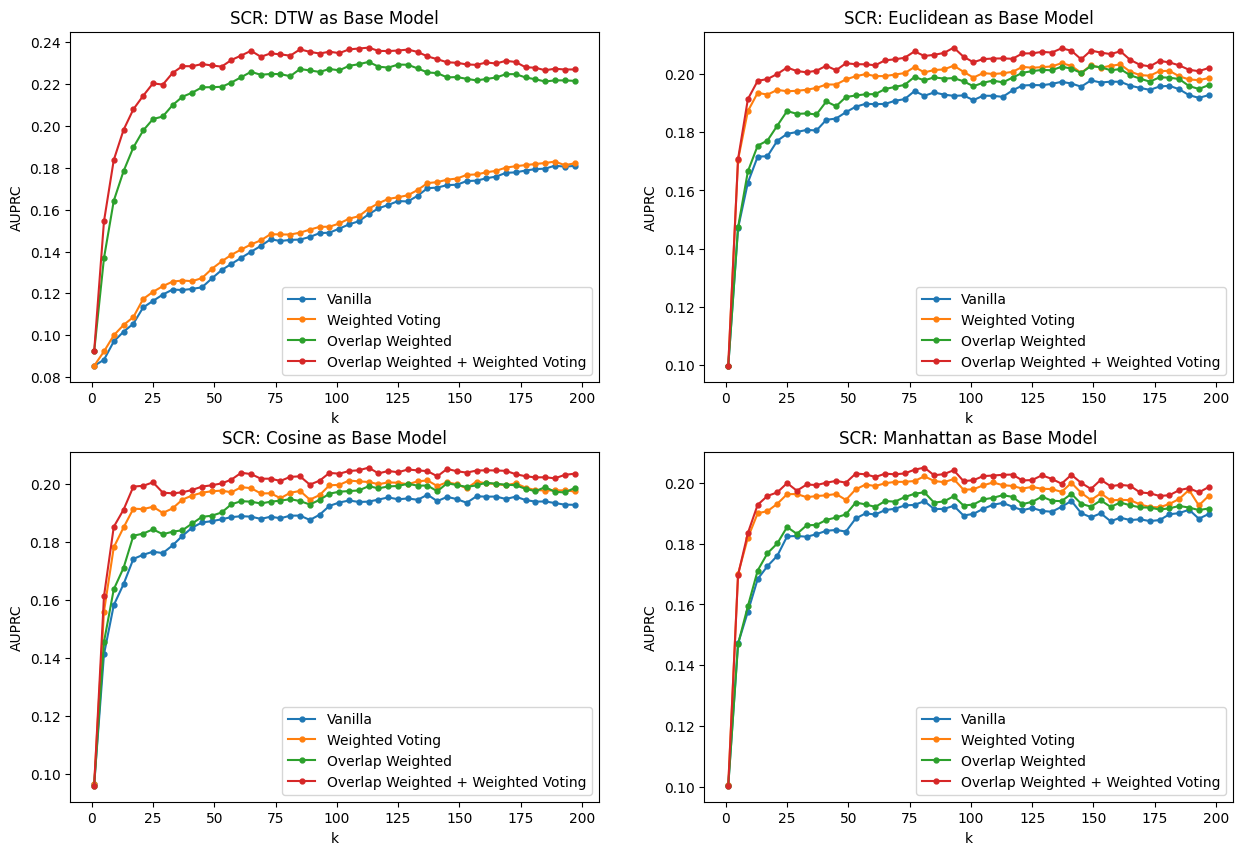

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUPRC"

plot_AUPRC_along_k(axs[0,0], 
                   k_sizes,
                   SCR_DTW_control["Vanilla"][metric], 
                   SCR_DTW_control["WV"][metric], 
                   SCR_DTW_control["OW"][metric], 
                   SCR_DTW_control["OW+WV"][metric], 
                   "SCR: DTW as Base Model")

plot_AUPRC_along_k(axs[0,1], 
                   k_sizes,
                   SCR_Euc_control["Vanilla"][metric], 
                   SCR_Euc_control["WV"][metric], 
                   SCR_Euc_control["OW"][metric], 
                   SCR_Euc_control["OW+WV"][metric], 
                   "SCR: Euclidean as Base Model")
plot_AUPRC_along_k(axs[1,0], 
                   k_sizes,
                   SCR_Cos_control["Vanilla"][metric], 
                   SCR_Cos_control["WV"][metric], 
                   SCR_Cos_control["OW"][metric], 
                   SCR_Cos_control["OW+WV"][metric], 
                   "SCR: Cosine as Base Model")
plot_AUPRC_along_k(axs[1,1], 
                   k_sizes,
                   SCR_Manh_control["Vanilla"][metric], 
                   SCR_Manh_control["WV"][metric], 
                   SCR_Manh_control["OW"][metric], 
                   SCR_Manh_control["OW+WV"][metric], 
                   "SCR: Manhattan as Base Model")

plt.show()

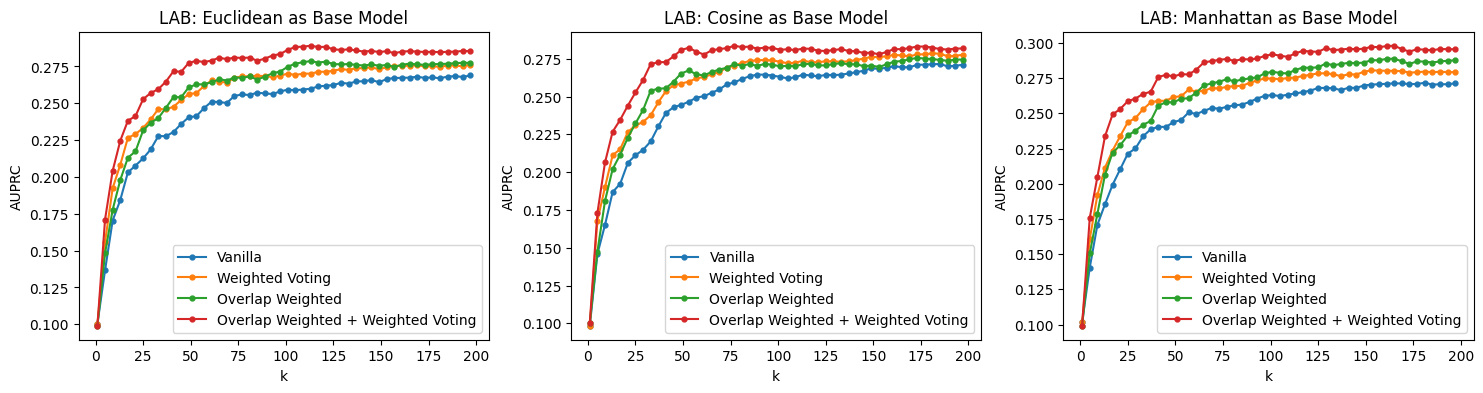

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUPRC"

plot_AUPRC_along_k(axs[0], 
                   k_sizes,
                   LAB_Euc_control["Vanilla"][metric], 
                   LAB_Euc_control["WV"][metric], 
                   LAB_Euc_control["OW"][metric], 
                   LAB_Euc_control["OW+WV"][metric], 
                   "LAB: Euclidean as Base Model")
plot_AUPRC_along_k(axs[1], 
                   k_sizes,
                   LAB_Cos_control["Vanilla"][metric], 
                   LAB_Cos_control["WV"][metric], 
                   LAB_Cos_control["OW"][metric], 
                   LAB_Cos_control["OW+WV"][metric], 
                   "LAB: Cosine as Base Model")
plot_AUPRC_along_k(axs[2], 
                   k_sizes,
                   LAB_Manh_control["Vanilla"][metric], 
                   LAB_Manh_control["WV"][metric], 
                   LAB_Manh_control["OW"][metric], 
                   LAB_Manh_control["OW+WV"][metric], 
                   "LAB: Manhattan as Base Model")

plt.show()